# Simulation - Projet

## Importation des modules nécessaires

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math
import seaborn as sns
import pandas as pd
import random

## Répartition des décimales d’exponentielle

### Premier aperçu

In [10]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


In [11]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les chiffres apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les chiffres apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


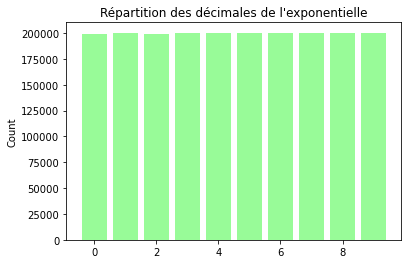

In [12]:
def construct_hist(labels, counts):
    plt.figure()
    plt.bar(labels, counts, color='palegreen')
    plt.title('Répartition des décimales de l\'exponentielle')
    plt.ylabel('Count')
    plt.savefig('histo_exp.png')
    plt.show()

construct_hist(e_labels, e_counts)

### Test du Chi-Carré

In [13]:
def chi_squarred(observed, theorical):
    kr = np.sum(((observed-theorical)**2)/theorical)
    critical = stat.chi2.ppf(q=0.95, df=len(observed)-1)
    return kr <= critical, kr, critical

def chi_squared_uniform(observed):
    proba = 1 / len(observed)
    N = sum(observed)
    theorical = np.array([N * proba for _ in range(len(observed))])
    return chi_squarred(observed, theorical)

print(f"Test du Chi-Carré pour les décimales d'exponentiells : \n"
      f"{chi_squared_uniform(e_counts)}")

Test du Chi-Carré pour les décimales d'exponentiells : 
(True, 8.65376, 16.918977604620448)


### Test du Poker

In [14]:
def poker_test(data):
    number_lists = len(data)/4
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        vals, cts = np.unique(li, return_counts=True)
        if len(cts) == 4:
            all_diff += 1
        elif len(cts) == 3:
            one_pair += 1
        elif len(cts) == 2:
            if 3 in cts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    return chi_squarred_poker(np.array([all_diff, one_pair, triplet, two_pair, quadr]), len(lists))

def chi_squarred_poker(observed, N):    # P(all_diff) > P(one_pair) > P(triplet) > P(two_pair) > P(quadr)
    probas = np.array([0.504, 0.432, 0.036, 0.027, 0.001])
    theorical = probas * N
    return chi_squarred(observed, theorical)

print(f"Test du Poker pour les décimales d\'exponentielle : \n"
      f"{poker_test(e_numbers)}")

Test du Poker pour les décimales d'exponentielle : 
(True, 1.2631547619047618, 9.487729036781154)


### Test du gap

In [15]:
def gap_test(data, proba, a, b):
    intervals = []
    length_series_not_in = 1
    total_gaps = 0
    sequence_length = 0
    for nb in data:
        if a <= nb < b:
            # nb in interval, with probability `probability`
            intervals.append(length_series_not_in)
            length_series_not_in = 1
        else:
            # nb not in interval
            length_series_not_in += 1
            total_gaps += 1
        sequence_length += 1
    labels, observed = np.unique(np.array(intervals), return_counts=True)
    print(f"labels {labels} observed {observed}")
    observed = complete_labels(labels, observed)
    theorical = np.array([(1 - proba)**(n+1) for n in range(max(labels))])*sum(observed)
    return chi_squarred(observed, theorical)

def gap_test_discrete(data, a: int = 0, b: int = 5, total_numbers: int = 10):
    assert a < b
    proba = (b - a) / total_numbers  # => proba 1/2 d'être marqué
    return gap_test(data, proba, a, b)

def complete_labels(labels, observed):
    res_labels = []
    res_observed = []
    n = 0
    j = 0
    for expected in range(1, np.max(labels)+1):
        label = labels[j-n]
        if expected != label:
            res_labels.append(expected)
            res_observed.append(0)
            n += 1
        else:
            res_labels.append(label)
            res_observed.append(observed[j-n])
            j += 1
    return res_observed


print(f"Test du Gap pour les décimales d'exponentielle : \n "
      f"{gap_test_discrete(e_numbers, 0, 5)}")

labels [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 23] observed [498508 250019 125357  62699  31187  15611   7818   3926   1995    956
    473    223    124     59     29     22      8      3      1      1]
Test du Gap pour les décimales d'exponentielle : 
 (True, 16.078953572083208, 33.92443847144381)


## Générateur de nombres aléatoires

### Technique employée

In [16]:
NB_DIGITS = 10

class Generator0:

    def __init__(self, seed=0, nb_digits = 10):
        self.seed = seed
        self.index = seed % len(e_numbers)
        self.nb_digits = nb_digits

    def random(self):
        digits = []
        for i in range(self.nb_digits):
            digit = e_numbers[self.index]
            digits.append(digit)
            self.index += 1
        return float("0." + "".join(map(lambda x: str(x), digits)))

class Generator1:

    def __init__(self, seed=0, nb_digits = 10):
        self.seed = seed
        self.index = seed % len(e_numbers)
        self.nb_digits = nb_digits

    def random(self):
        digits = []
        for i in range(self.nb_digits):
            nb = e_numbers[self.index]
            a = len(e_numbers) - nb
            c = e_numbers[i + nb]
            digit = (a * nb + c) % 10
            digits.append(digit)
            self.index += 1
        return float("0." + "".join(map(lambda x: str(x), digits)))
        

class Generator2:

    def __init__(self, seed=0, nb_digits = 10):
        self.seed = seed
        self.index = seed % len(e_numbers)
        self.nb_digits = nb_digits
    
    def random(self):
        xyz = []
        for j in range(3):
            digits = []
            for k in range(self.nb_digits):
                digit = e_numbers[self.index]
                digits.append(digit)
                self.index += 1
            xyz.append(float("0." + "".join(map(lambda x: str(x), digits))))
        yield math.sqrt(sum([x**2 for x in xyz]))/math.sqrt(3)

class Generator3:

    def __init__(self, seed=0, precision=57):
        self.seed = seed
        self.index = seed % len(e_numbers)
        self.precision = precision          # IEE754 double has 57 bits of precision

    def random(self):
        bits = 0
        generated = 0
        while bits < self.precision:
            rn = e_numbers[self.index]

            if rn > 7:
                self.index = (self.index + 1) % len(e_numbers)
                continue

            three_bits = (
                rn & 1,
                (rn & 2) // 2,
                (rn & 4) // 4
            )
            
            for i in range(3):
                if bits >= self.precision:
                    break
                generated = (generated << 1) | three_bits[i]
                bits += 1

            self.index = (self.index + 1) % len(e_numbers)
        return generated / 2**self.precision

rng0 = Generator0(50)
rng1 = Generator1(50)
rng2 = Generator2(50)
rng3 = Generator3(50)
gen_numbers = [rng1.random() for _ in range(50)]
print(f"Résultat de notre générateur : \n"
      f"{gen_numbers}")

Résultat de notre générateur : 
[0.3356334294, 0.2856488696, 0.3123309692, 0.2357304731, 0.6877939038, 0.4928991741, 0.4189801214, 0.4756094296, 0.4486305044, 0.7926444094, 0.6478315694, 0.3827634648, 0.3582035001, 0.4885615504, 0.3343011284, 0.0359699794, 0.3986881544, 0.4416345391, 0.2726911048, 0.3616914894, 0.4848208236, 0.4556271891, 0.3549209318, 0.3912005284, 0.3926344292, 0.6316885831, 0.3022984701, 0.0916905284, 0.3342281601, 0.4678881694, 0.2926075084, 0.3189405244, 0.4926319688, 0.3822944234, 0.4189011336, 0.3819901285, 0.6313011894, 0.2626081735, 0.6825311345, 0.6178305846, 0.3986609342, 0.2488049896, 0.2576314294, 0.3918331845, 0.3189611635, 0.392801103, 0.282934404, 0.3623081014, 0.4829644741, 0.261239181]


### Test du Chi Carré

In [17]:
def split_in_groups(data):
    data = np.sort(data)
    i = 0
    count = 0
    res = []
    for d in data:
        if i <= d < (i + 0.1):
            count += 1
        else:
            i += 0.10000000000000000000000000
            res.append(count)
            count = 0
    return np.array(res)

def chi_squared_continuous(data):
    observed = split_in_groups(data)
    N = len(data)
    proba = 1/len(observed)
    theorical = np.array([N * proba for _ in range(len(observed))])
    return chi_squarred(observed, theorical)

print(f"Test du Chi Carré pour notre générateur : \n"
      f"{chi_squared_continuous(gen_numbers)}")

Test du Chi Carré pour notre générateur : 
(False, 41.13999999999999, 12.591587243743977)


### Test de Kolmogorov-Smirnov

In [18]:
def kolmogorov_smirnov(numbers):
    np.sort(numbers)
    n = len(numbers)
    distance = np.max(np.array([np.abs((i/n)-numbers[i]) for i in range(len(numbers))]))
    critical = 1.358/math.sqrt(n)
    return distance < critical, distance, critical

print(f"Test de Kolmogorov-Smirnov pour notre générateur : \n"
      f"{kolmogorov_smirnov(gen_numbers)}")

Test de Kolmogorov-Smirnov pour notre générateur : 
(False, 0.718760819, 0.19205020177026633)


### Test du gap

In [19]:
def gap_test_continue(data, a = 0.0, b = 0.5):
    assert a < b
    proba = b - a  # => proba 1/2 d'être marqué
    return gap_test(data, proba, a, b)

print(f"Test du gap pour notre générateur : \n"
      f"{gap_test_continue(gen_numbers, 0.0, 0.5)}")

labels [1 2 3] observed [38  3  2]
Test du gap pour notre générateur : 
(False, 20.36918604651163, 5.991464547107979)


### Comparaison avec le générateur de Python

In [20]:
numbers_python = []
for _ in range(len(gen_numbers)):
    numbers_python.append(random.uniform(0, 1))

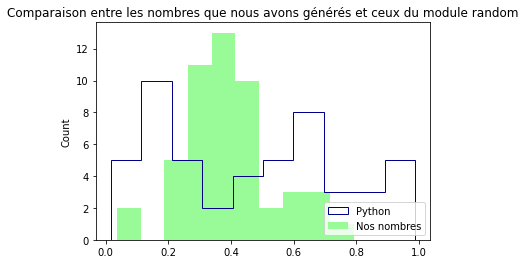

In [21]:
def comp_histo(data_1, data_2):
    plt.figure()
    plt.hist(data_2, color='palegreen', histtype='barstacked')
    plt.hist(data_1, color='darkblue', histtype='step')
    plt.legend({'Nos nombres', 'Python'}, loc=4)
    plt.title("Comparaison entre les nombres que nous avons générés et ceux du module random")
    plt.ylabel('Count')
    plt.savefig('histo_comp.png')
    plt.show()

comp_histo(numbers_python, gen_numbers)